Рассмотрим задачу минимизации кусочно-линейной функции на сфере
\begin{equation}
\begin{split}
&\min_{x\in R^n} \left \{ f(x) = \max_{1 \leq i \leq k} (a_i^Tx -b_i) \right \}\\
&\text{subject to}\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}



# Nesterov Smoothing

Решим данную задачу с помощью быстрого градиентного метода Нестерова

https://link.springer.com/content/pdf/10.1007/s10107-004-0552-5.pdf



Из метода сглаживания Нестерова, требуется представить 
$$f(x) = g(x) + h(x)$$, где $$h(x)$$ имеет форму записи через максимум

В нашем случае представим 
$$h(x) = \max_{1 \leq i \leq k} (a_i^Tx -b_i)$$

$$g(x) = 0$$

Тогда заметим, что аналогично подходу в оригинальной статье, мы можем сконструировать матрицу A, строками которой будут являться $a_i$. Для выбора i элемента матрицы А и вектора b, введем переменную u принадлежащую единичному симплексу. А также выберем функции $d_1$ и $d_2$ аналогично оригинальной статье. А также учтем ограничения, выбирая х только из допустимого множества

Таким образом,

$$ Q_1 = \{x: ||x-x_0||_2^2 \leq \sigma^2 \}$$
$$ d_1(x) = \cfrac{1}{2} ||x-x_0||^2_2, \quad \sigma_1 = 1, \quad D_1 = \cfrac{\sigma^2}{2} $$

$$ Q_2 = \Delta_k $$
$$ d_2(u) = \sum\limits_{i=1}^k u_i \log u_i + \log k, \quad \sigma_2 = 1, \quad D_2 = \log k $$


Задавшись первой и второй нормой в наших функциях, аналогично оригинальной статье получим
$$||A||^2_{1,2} = \lambda_{max}^{1/2}(A^TA)$$
Тогда, L выразится следующим образом:
$$L = \cfrac{1}{\mu}  \lambda_{max}^{1/2}(A^TA)$$



Следовательно,

$$f_\mu(x) = h_\mu(x) = \max_{u \in \Delta_k} ( u^TAx -  u^Tb - \mu d_2(u))$$

Аналогично оригинальной статье

$$f_\mu(x) =  \mu \log \cfrac{1}{k} \sum\limits_{i=1}^k \exp \frac{a_i^Tx-b_i}{\mu}$$

Тогда 

$$\nabla f_\mu(x) = A^T u^*(x) = A^T \cfrac{\exp \cfrac{Ax-b}{\mu}}{\sum\limits_{i=1}^k \exp \cfrac{a_i^Tx-b_i}{\mu}}$$

Для реализации схемы нам также потребуется $z_k$ и $y_k$

$$
z_k = argmin_{x \in Q_1} \cfrac{L}{\sigma_1}d_1(x) + \sum\limits_{i=0}^k \cfrac{i+1}{2}(f_\mu(x_i)+<\nabla f_\mu(x_i),x-x_i>)  = argmin_{x \in Q_1}  L\cfrac{1}{2} ||x-x_0||^2_2 + \sum\limits_{i=0}^k \cfrac{i+1}{2}<\nabla f_\mu(x_i),x> $$

$$\nabla (L\cfrac{1}{2} ||x-x_0||^2_2 + \sum\limits_{i=0}^k \cfrac{i+1}{2}<\nabla f_\mu(x_i),x> )= L(x-x_0) + \sum\limits_{i=0}^k \cfrac{i+1}{2} \nabla f_\mu(x_i) \Rightarrow z_k = \pi_{Q_1}(x_0 - \frac{1}{L} \sum\limits_{i=0}^k \frac{i+1}{2}\nabla f_{\mu}(x_i)).
$$


$$
y_k = argmin_{x \in Q_1}  \cfrac{1}{2}L ||x-x_k||_2^2 + <\nabla f_\mu(x_k),x-x_k> = argmin_{x \in Q_1} \cfrac{1}{2}L||x-x_k||_2^2 + <\nabla f_{\mu}(x_k),x> $$


$$\nabla ( \cfrac{1}{2}L||x-x_k||_2^2 + <\nabla f_{\mu}(x_k),x> )= L(x - x_k) + \nabla f_{\mu}(x_k) \Rightarrow \pi_{Q_1} \, (x_k - \cfrac{\nabla f_{\mu}(x_k)}{L})$$



Посчитаем $\pi_{Q_1}(x)$, для чего выпишем явный вид проекции и решим по ККТ
$$
\min_{z} \cfrac{1}{2} ||z-x ||^2_2$$


$$s.t. ||z-x_0||^2_2 \leq \sigma^2 $$

$$
L = \frac{1}{2} ||z-x ||^2_2 + \lambda (||z-x_0||^2_2 -\sigma^2 )
$$

$$
1) z - x + \lambda(z-x_0) = 0, \quad z = \cfrac{x+\lambda x_0}{1+\lambda}
$$

$$
2) ||z-x_0||^2_2 -\sigma^2 \leq 0
$$

$$
3) \lambda (||z-x_0||^2_2 -\sigma^2 )=0
$$


$$
4) \lambda \geq 0
$$


$$ \pi_{Q_1}(x) =
  \begin{cases}
    x       & \quad \text{if } x \in Q_1\\
    \cfrac{x + x_0 (\cfrac{||x-x_0||_2}{\sigma}-1)}{\cfrac{||x-x_0||_2}{\sigma}}  & \quad \text{othewise}
  \end{cases}
$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
f_mu = lambda x: mu * (1/m) * np.log(np.sum(np.exp((A @ x - b) / mu)))

f_mu_grad = lambda x: A.T @ np.exp((A @ x - b) / mu) / np.sum(np.exp((A @ x - b) / mu))


def projection(x):
    #print(np.linalg.norm(x - x_0))
    if (np.linalg.norm(x - x_0))**2 <= sigma**2:
        return x
    else:
        lam = (np.linalg.norm(x - x_0)/sigma - 1)
        return (x + x_0 * lam) / (lam+1)
    
def update_y(x, grad_ls):
    return projection(x - grad_ls[-1]/L)
    
def update_z(grad_ls):
    grads_mult_ls = [(j+1) * grad_ls[j] / 2 for j in range(len(grad_ls))]
    return projection(x_0 - np.sum(grads_mult_ls)/L)
    
def NesterovSmoothing(f_mu_grad, x_0, num_iter, time_limit=None):
    if time_limit:
        time_start = time.time()
        time_ls = [0]
        
    
    x = x_0.copy()
    conv = [x_0]
    grad_ls = [f_mu_grad(x_0)]
    for i in tqdm(range(num_iter)):
        y = update_y(x, grad_ls)
        z = update_z(grad_ls)
        x = z * 2 / (i+3)  + y * (i+1) / (i+3)
        conv.append(x.copy())
        grad_ls.append(f_mu_grad(x.copy()))
        
        if time_limit:
            time_end = time.time()
            time_delta = time_end-time_start
            time_ls.append(time_delta)
            if time_delta > time_limit:
                break
    return x, conv, time_ls

In [3]:
seed = 0xAB0BA
np.random.seed(seed)
n = 1000
m = 100
A = np.random.randn(m, n)
b = np.random.randn(m)
x = np.random.randn(n)

sigma = 2
x_0 = np.random.randn(n)
mu = 10
L = np.sqrt(np.linalg.eigh(A.T@A)[0].max())/ mu

max_iter = 500

In [5]:
res, fgm = NesterovSmoothing(f_mu_grad, x_0, max_iter)

100%|██████████| 500/500 [00:02<00:00, 207.87it/s]


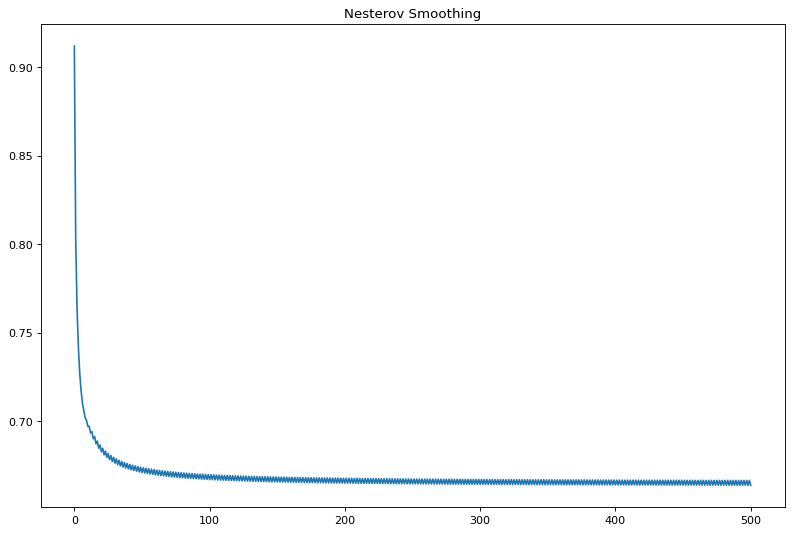

In [6]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot([f_mu(x) for x in fgm])
plt.title('Nesterov Smoothing')
plt.show()

# Барьерный метод с оптимизацией методом Ньютона

Указанная выше задача может быть записана в эквивалентном виде

\begin{equation}
\begin{split}
&\min_{x\in R^n, t} t \\
&\text{subject to}\\
&a_i^Tx -b_i \leq t, \quad 1\leq i\leq k\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}

Перепишем задачу заменим ограничение неравенств на индикаторные функции

$$\min_{x\in R^n, t} t + \sum\limits_{i=1}^k \mathbb{1}(a_i^Tx - b_i - t) + \mathbb{1}(||x-x_0||_2^2 - \sigma^2)$$

Здесь индикаторная функция принимает 0 если ограничение выполняется и +бесконечность иначе

Функция стала не дифференцируемая, поэтому сгладим ее логарифмическим барьером

$\hat{I}(u) = -\beta \log(-u)$
и при $\beta \rightarrow 0 \quad \hat{I}(u) \rightarrow \mathbb{1}(u)$

Таким образом мы получим 

$$\min_{x\in R^n, t} t + \sum\limits_{i=1}^k \hat{I}(a_i^Tx - b_i - t) + \hat{I}(||x-x_0||_2^2 - \sigma^2) = 
t - \beta \sum\limits_{i=1}^k \log(-a_i^Tx + b_i + t) - \beta\log(-||x-x_0||_2^2 + \sigma^2)
$$


$$\nabla f_x = \beta(\sum\limits_{i=1}^k \cfrac{-a_i}{(a_i^Tx - b_i - t)} - \cfrac{2(x-x_0)}{-\sigma^2 + ||x-x_0||_2^2})$$

$$\nabla f_t = 1 + \beta\sum\limits_{i=1}^k \cfrac{1}{(a_i^Tx - b_i - t)}$$


$$H_f = \begin{bmatrix}
A & B\\
C & D
\end{bmatrix}$$

$A = \cfrac{\partial f}{\partial x^2} = \beta(\sum\limits_{i=1}^k \cfrac{a_ia_i^T}{(a_i^Tx - b_i - t)^2} - \cfrac{2( 2(x-x_0)(x-x_0)^T + I(\sigma^2 - ||x-x_0||_2^2) )}{(-\sigma^2 + ||x-x_0||_2^2)^2})$

$B = \cfrac{\partial f}{\partial x \partial t} = \beta\sum\limits_{i=1}^k \cfrac{-a_i}{(a_i^Tx - b_i - t)^2}$

$C = \cfrac{\partial f}{\partial t \partial x}= \beta\sum\limits_{i=1}^k \cfrac{a_i^T}{(a_i^Tx - b_i - t)^2}$

$D = \cfrac{\partial f}{\partial t^2} = \beta\sum\limits_{i=1}^k \cfrac{1}{(a_i^Tx - b_i - t)^2}$



Теперь осталось только оптимизировать нашу функцию методом Ньютона и уменьшать параметр $\beta$ логарифмического барьера

$$(x_{k+1},t_{k+1}) = (x_{k},t_{k}) - H_{f(x_k, t_k)}^{-1} \nabla f(x_k,t_k)$$


Неплохая статья из которой становилось понятней что происходит https://towardsdatascience.com/how-to-solve-constrained-optimization-problem-the-interior-point-methods-1733095f9eb5

In [7]:
n = 100
m = 10
A = np.random.randn(m, n)
b = np.random.randn(m)
x = np.random.randn(n)


max_iter = 500
sigma = 2
x_0 = np.random.randn(n)
beta = 0.1
x0 = x_0 + 0.0001
t0 = np.max(A @ x0 - b) + 0.0001
alpha = 0.01
v = (1 + 1/(13 * np.sqrt(0.001)))
tol_barrier = 1e-3 


In [4]:
def f(beta, x, t):
    first_constraint = (beta* np.log(-A @ x + b + t)).sum()
    second_constraint = beta*np.log(-np.linalg.norm(x-x_0)**2 + sigma**2)
    return (t - first_constraint - second_constraint) 

def f_grad_x(beta, x, t):
    first_elem = np.sum([-beta*A[i]/(A[i] @ x - b[i] - t) for i in range(m)], axis = 0)
    second_elem = (2 * beta * (x-x_0))/(-sigma**2 + np.linalg.norm(x-x_0)**2)
    return first_elem - second_elem 


def f_grad_t(beta, x, t):
    return 1 + (beta / (A @ x - b - t)).sum()

def f_grad(beta, x, t):
    
    return np.hstack([f_grad_x(beta, x, t), f_grad_t(beta, x, t)])

def A_(beta, x, t):
    first_elem = np.sum([beta * (A[i].reshape(-1,1) @ A[i].reshape(1,-1)) / (A[i] @ x - b[i] -t)**2 for i in range(m)],axis = 0)
    numerator = beta * 2 * (-2 * (x-x_0).reshape(-1,1) @ (x-x_0).reshape(1,-1) + (np.linalg.norm(x-x_0) ** 2 - sigma ** 2) * np.eye(n))
    denominator = (- sigma**2 + np.linalg.norm(x-x_0) ** 2) ** 2
    second_elem =  numerator / denominator
    return first_elem - second_elem
    
def B(beta, x, t):
    return np.sum([-beta*A[i]/(A[i] @ x - b[i] - t)**2 for i in range(m)], axis = 0).reshape(-1,1)
    
def C(beta, x, t):
    return np.sum([-beta*A[i]/(A[i] @ x - b[i] - t)**2 for i in range(m)], axis = 0)

def D(beta, x, t):
    return (beta / (A @ x - b - t)**2).sum()
    
def Hessian(beta, x, t):

    return np.vstack([np.hstack([A_(beta, x, t), B(beta, x, t)]), np.hstack([C(beta, x, t) , D(beta, x, t)])])

def compute_duality_gap(k, beta, tol_barrier):
    return ((k+1)*beta > tol_barrier)

In [5]:
def Interior_point_method(x0, t0, beta, num_iter, f, f_grad, Hessian, alpha, tol_barrier, time_limit=None):    
    
    if time_limit:
        time_start = time.time()
        time_ls = [0]
    
    conv = [(x0.copy(), t0.copy(), beta)]
    
    x = x0.copy()   
    t = t0.copy()
    
    func_decreasing = True
    duality_gap = True
    while (func_decreasing and duality_gap) : 

        for i in tqdm(range(num_iter)):
            
            H = Hessian(beta, x, t)
            nabla = f_grad(beta, x, t)
            
            y = np.linalg.solve(H, -nabla)
            
            x = x + alpha*y[:-1]    
            t = t + alpha*y[-1]
            
            if f(beta , x, t) > f(conv[-1][2], conv[-1][0], conv[-1][1]):
                func_decreasing = False
                break
                
            if time_limit:
                time_end = time.time()
                time_delta = time_end - time_start
                time_ls.append(time_delta)
                if time_delta > time_limit:
                    func_decreasing = False
                    break               
           
            conv.append((x,t,beta))

        beta /= v
        
        duality_gap = compute_duality_gap(m,beta,tol_barrier)

    return x, conv, time_ls

In [10]:
x_IP, conv = Interior_point_method(x0, t0, beta, max_iter, f, f_grad, Hessian, alpha, tol_barrier)

  0%|          | 0/500 [00:00<?, ?it/s]


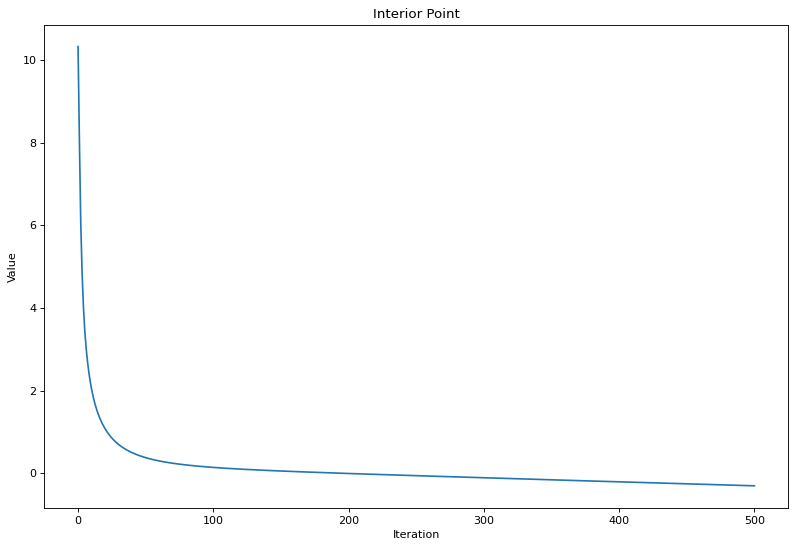

In [11]:
plt.figure(figsize = (12, 8), dpi = 80)
plt.plot([f(beta, x, t) for x,t,beta in conv ])
plt.title("Interior Point")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.show()


# Протестируем на разных данных

Сгенерируем искусственные (случайные) данные для тестирования алгоритмов.

Нам хочется сравнить эффективность методов для различной размерности задачи (то есть при росте $n$ и $k$). Из соображений вычислимости ограничим время вычисления на каждый инстанс 1000с.

  0%|          | 0/500 [00:00<?, ?it/s]


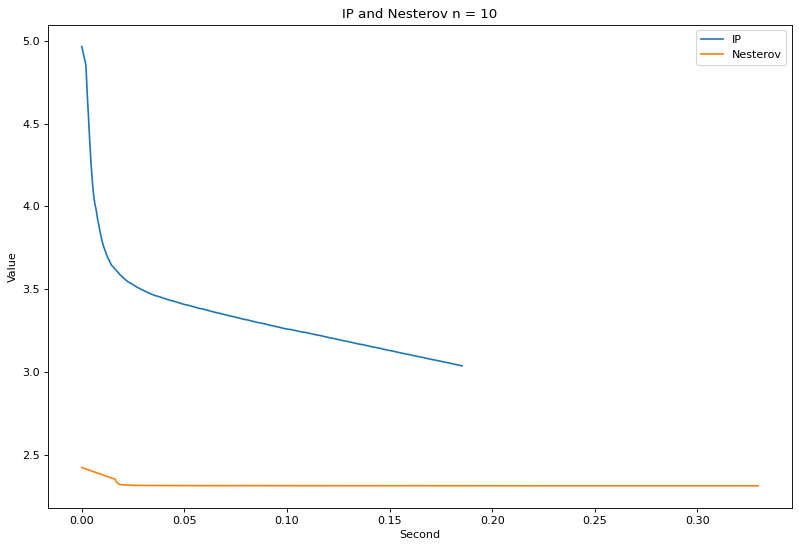

  0%|          | 0/500 [00:00<?, ?it/s]


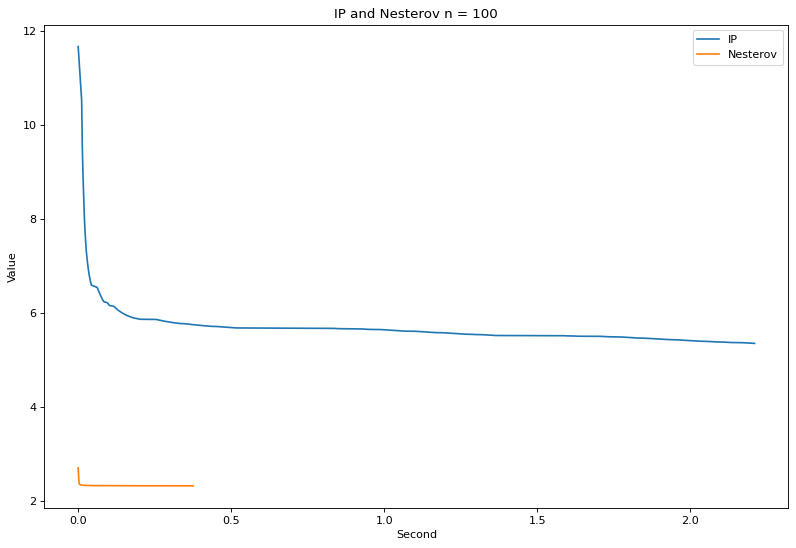

  0%|          | 0/500 [00:00<?, ?it/s]


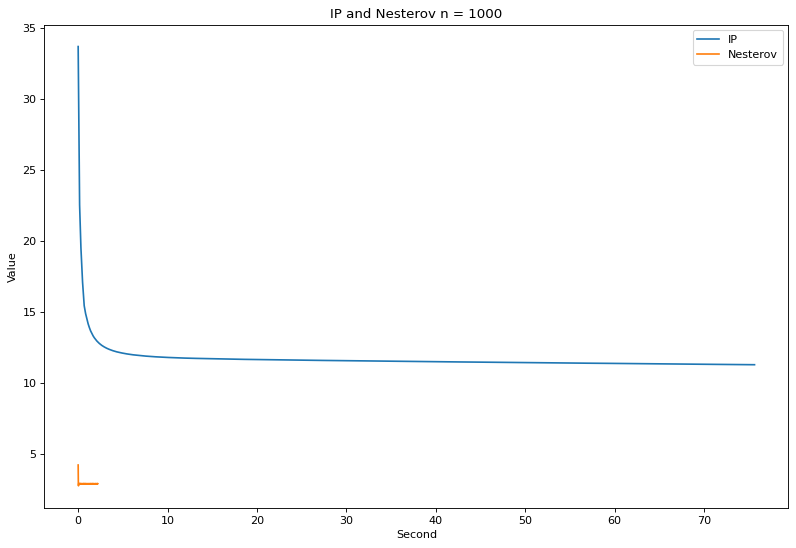

In [7]:
m = 10
n_ls = [10, 100, 1000] #дальше ядро просто умирает :(

sigma = 1
beta = 0.1
alpha = 0.01
v = (1 + 1/(13 * np.sqrt(0.001)))
mu = 10

max_iter = 500
TL = 1000
tol_barrier = 1e-3 



res_IP = []
res_Nesterov = []

for n in n_ls:
    A = np.random.randn(m, n)
    b = np.random.randn(m)
    x_0 = np.random.randn(n)
    x0 = x_0 + 0.0001

    t0 = np.max(A @ x0 - b) + 0.0001

    L = np.sqrt(np.linalg.eigh(A.T@A)[0].max())/ mu

    res, fgm, time_Nesterov = NesterovSmoothing(f_mu_grad, x_0, max_iter, time_limit = TL)
    
    #print(n, 'Nesterov converged')
    x_IP, conv, time_IP = Interior_point_method(x0, t0, beta, max_iter, f,
                                       f_grad, Hessian, alpha, tol_barrier, time_limit = TL)
    

    #print(n, 'IP converged')
    
    
    plt.figure(figsize = (12, 8), dpi = 80)
    plt.plot(time_IP, [f(beta, x, t) for x,t,beta in conv], label = 'IP')
    plt.plot(time_Nesterov, [f_mu(x) for x in fgm], label = 'Nesterov')
    plt.title("IP and Nesterov n = {}".format(n))
    plt.xlabel("Second")
    plt.ylabel("Value")
    plt.legend()

    plt.show()

100%|██████████| 500/500 [00:00<00:00, 2182.11it/s]


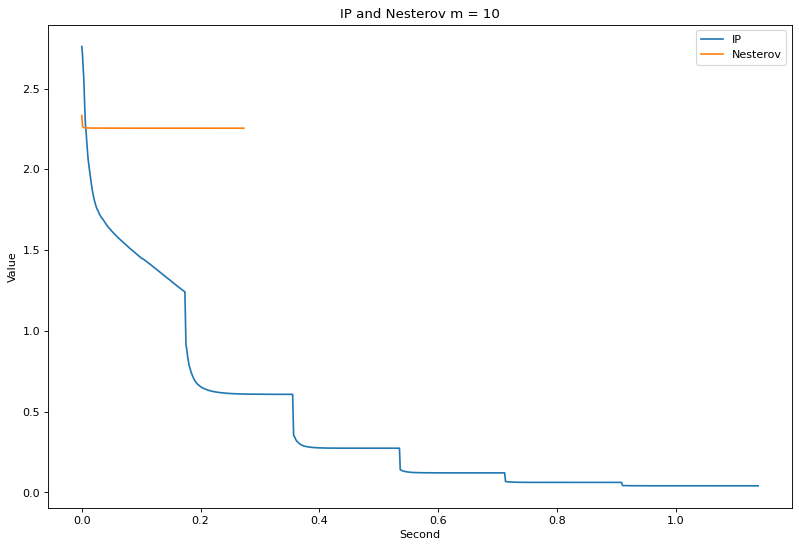

  0%|          | 0/500 [00:00<?, ?it/s]


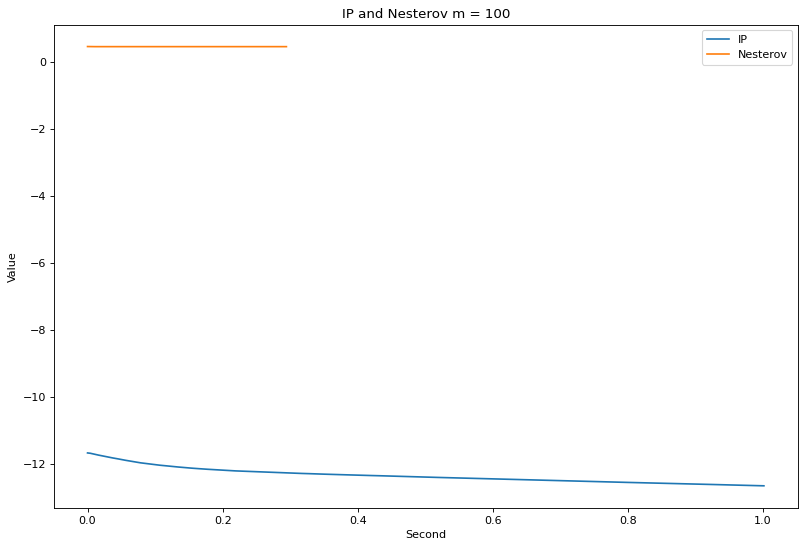

  0%|          | 0/500 [00:00<?, ?it/s]


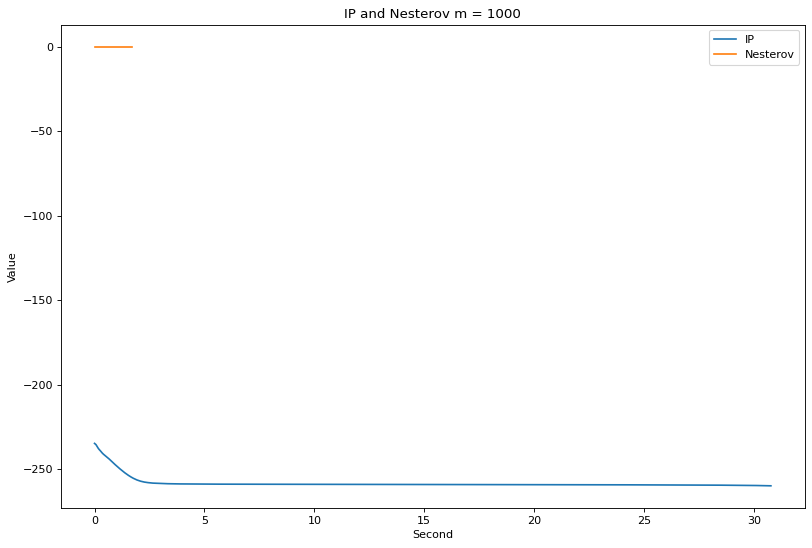

In [8]:
n = 10
m_ls = [10, 100, 1000] #дальше ядро просто умирает :(

sigma = 1
beta = 0.1
alpha = 0.01
v = (1 + 1/(13 * np.sqrt(0.001)))
mu = 10

max_iter = 500
TL = 1000
tol_barrier = 1e-3 


A = np.random.randn(m, n)
b = np.random.randn(m)
x_0 = np.random.randn(n)
x0 = x_0 + 0.0001

t0 = np.max(A @ x0 - b) + 0.0001

mu = 10
L = np.sqrt(np.linalg.eigh(A.T@A)[0].max())/ mu

res_IP = []
res_Nesterov = []

for m in m_ls:
    A = np.random.randn(m, n)
    b = np.random.randn(m)
    x_0 = np.random.randn(n)
    x0 = x_0 + 0.0001

    t0 = np.max(A @ x0 - b) + 0.0001

    L = np.sqrt(np.linalg.eigh(A.T@A)[0].max())/ mu

    res, fgm, time_Nesterov = NesterovSmoothing(f_mu_grad, x_0, max_iter, time_limit = TL)
    
    #print(n, 'Nesterov converged')
    x_IP, conv, time_IP = Interior_point_method(x0, t0, beta, max_iter, f,
                                       f_grad, Hessian, alpha, tol_barrier, time_limit = TL)
    

    #print(n, 'IP converged')
    
    
    plt.figure(figsize = (12, 8), dpi = 80)
    plt.plot(time_IP, [f(beta, x, t) for x,t,beta in conv], label = 'IP')
    plt.plot(time_Nesterov, [f_mu(x) for x in fgm], label = 'Nesterov')
    plt.title("IP and Nesterov m = {}".format(m))
    plt.xlabel("Second")
    plt.ylabel("Value")
    plt.legend()

    plt.show()

100%|██████████| 500/500 [00:00<00:00, 3953.77it/s]


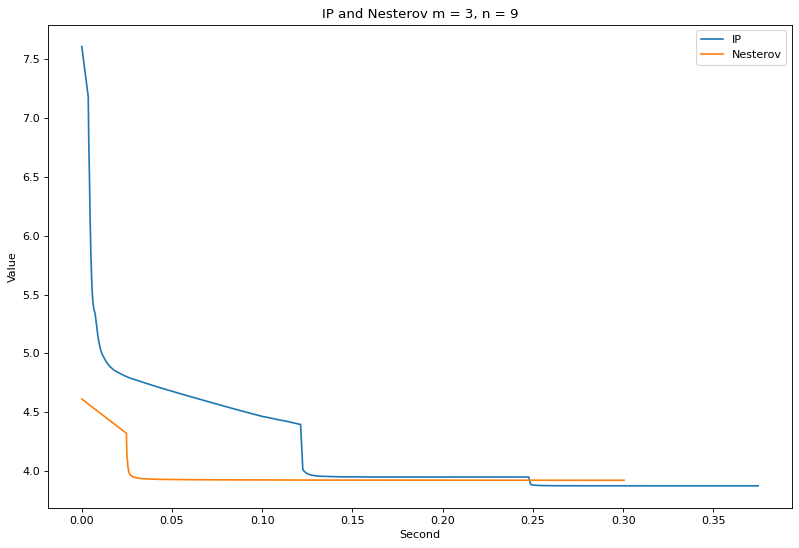

  0%|          | 0/500 [00:00<?, ?it/s]/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 500/500 [00:03<00:00, 146.12it/s]


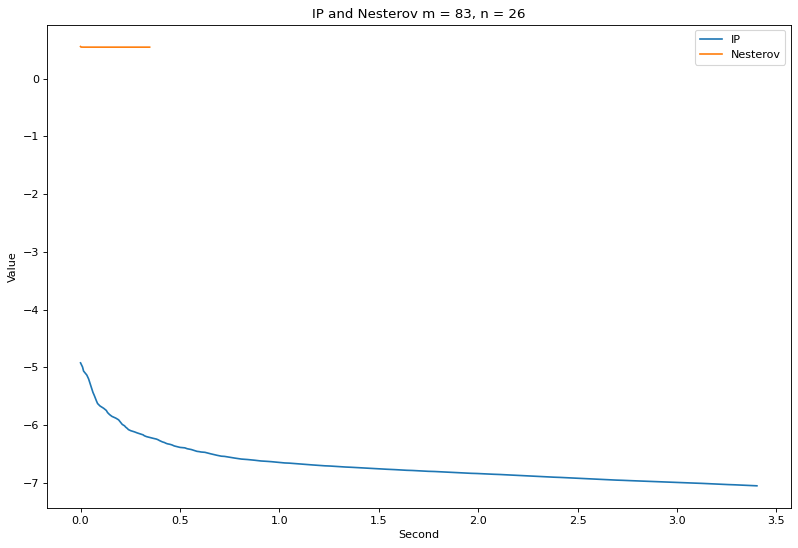

100%|██████████| 500/500 [04:17<00:00,  1.94it/s]


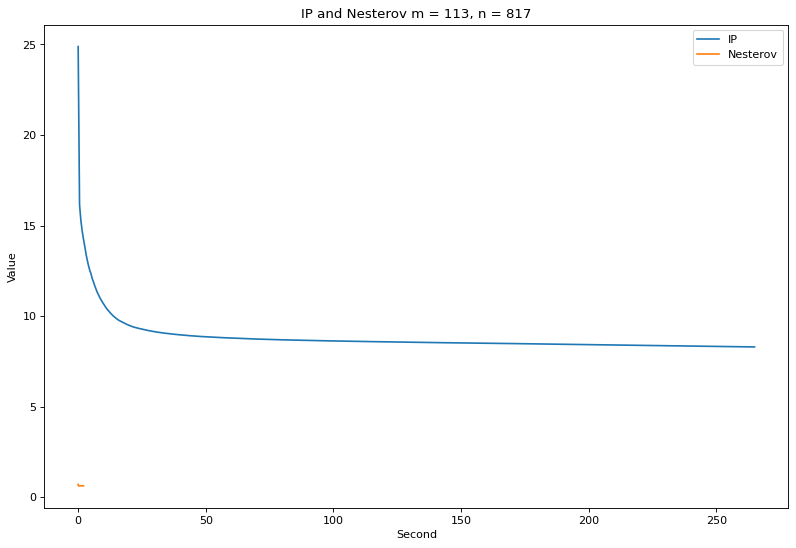

In [6]:
value_to_random = [10, 100, 1000] #дальше ядро просто умирает :(

sigma = 1
beta = 0.1
alpha = 0.01
v = (1 + 1/(13 * np.sqrt(0.001)))
mu = 10

max_iter = 500
TL = 1000
tol_barrier = 1e-3 



res_IP = []
res_Nesterov = []

for v in value_to_random:
    n = np.random.randint(1, v)
    m = np.random.randint(1, v)
    
    A = np.random.randn(m, n)
    b = np.random.randn(m)
    x_0 = np.random.randn(n)
    x0 = x_0 + 0.0001

    t0 = np.max(A @ x0 - b) + 0.0001

    L = np.sqrt(np.linalg.eigh(A.T@A)[0].max())/ mu

    res, fgm, time_Nesterov = NesterovSmoothing(f_mu_grad, x_0, max_iter, time_limit = TL)
    
    #print(n, 'Nesterov converged')
    x_IP, conv, time_IP = Interior_point_method(x0, t0, beta, max_iter, f,
                                       f_grad, Hessian, alpha, tol_barrier, time_limit = TL)
    

    #print(n, 'IP converged')
    
    
    plt.figure(figsize = (12, 8), dpi = 80)
    plt.plot(time_IP, [f(beta, x, t) for x,t,beta in conv], label = 'IP')
    plt.plot(time_Nesterov, [f_mu(x) for x in fgm], label = 'Nesterov')
    plt.title("IP and Nesterov m = {}, n = {}".format(m, n))
    plt.xlabel("Second")
    plt.ylabel("Value")
    plt.legend()

    plt.show()